# 1: Slab model
---------------

This notebook computes an infrared spectrum following a slab model with a black body as central star.

_This exercise was originally written by Michel Hillen in 2015, following the original IDL code of Tijl Verhoelst, then modified by Ana Escorza in 2016, and finally by Frederik De Ceuster in 2024._

In [1]:
import numpy                 as np
import matplotlib.pyplot     as plt

from astropy                 import units
from astropy.modeling.models import BlackBody
from astropy.visualization   import quantity_support

In [14]:
# Define the model parameters
temperature_star = 3000
temperature_slab = 1000
theta_star       = 10
theta_slab       = 30
column_density   = 1.0e+18

Now read the water opacity file for the chosen slab temperature (note it must be between 500 and 2500 K in multiples of 100)

In [15]:
# Read opacity file
opacity_file        = 'data/H2O_tau_{:04d}K.txt'.format(temperature_slab)
wavelength, opacity = np.loadtxt(opacity_file, skiprows=1, unpack=True)

# Attach astropy units
wavelength *= units.nm
opacity    *= units.cm**2

In [16]:
# Attach units to the model parameters
temperature_star *= units.K
temperature_slab *= units.K
theta_star       *= units.mas
theta_slab       *= units.mas
column_density   *= units.cm**(-2)

In [17]:
def convolve_with_gaussian(x, y, width):

    # Convert from the FWHM to the constant in the Gaussian
    width = width/(2.0*np.sqrt(2.0*np.log(2.0)))
    
    n = len(x)
    width_pix = width / ((x[n-1]-x[0])/n)
    
    nker = 20 * np.floor(width_pix)
    z = (np.arange(nker) - np.floor(nker/2)) / width_pix
    kernel = np.exp(-0.5 * z**2)
    
    # we want flux conservation
    normalisation_factor=kernel.sum()
    
    # convolving
    result = (1.0/normalisation_factor) * np.convolve(y, kernel, mode='same')

    return result

Optical depth, assuming a constant opacity and density along the line-of-sight,
\begin{equation}
    \tau_{\nu} \ = \ \kappa_{\nu} \, \rho \, d
\end{equation}
Solution of the radiative transfer equation, assuming a constant source function, $S_{\nu}$, along the line-of-sight,
\begin{equation}
    I_{\nu} \ = \ I^{\text{bdy}}_{\nu} \, e^{-\tau_{\nu}} \ + \ S_{\nu} \left( 1 - e^{-\tau_{\nu}} \right) .
\end{equation}

In [18]:
bb_star = BlackBody(temperature=temperature_star)
bb_slab = BlackBody(temperature=temperature_slab)

# Optical depth through slab (assuming a constant density and opacity along the line-of-sight)
optical_depth = opacity * column_density

# Spectrun of star
spec_star =   bb_star(wavelength) * np.pi * theta_star**2

# Spectrun of star after trasfer through slab
spec_slab =   bb_star(wavelength) * np.pi * theta_star**2 *      np.exp(-optical_depth) \
            + bb_slab(wavelength) * np.pi * theta_slab**2 * (1 - np.exp(-optical_depth))

# Spectrum convolved with Gaussian beam
spec_conv = convolve_with_gaussian(wavelength, spec_slab, width=3.0*units.nm)


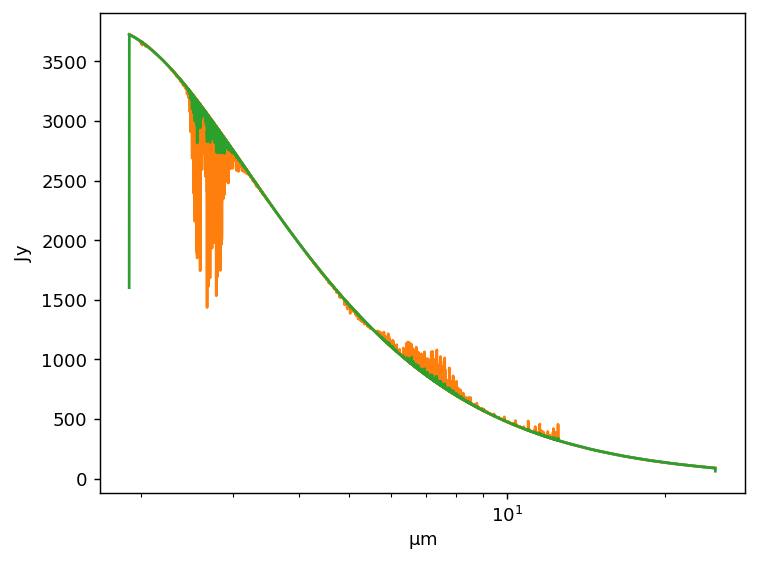

In [19]:
with quantity_support():
    plt.figure(dpi=130)
    plt.plot(wavelength.to(units.micron), spec_star.to(units.Jansky))
    plt.plot(wavelength.to(units.micron), spec_slab.to(units.Jansky))
    plt.plot(wavelength.to(units.micron), spec_conv.to(units.Jansky))
    plt.xscale('log')

Note that the first and last point in the convolved spectrum are affected by boundary issues of the convolution.